In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
plt.rcParams["figure.figsize"] = (25,15)
plt.rcParams.update({'font.size': 22})

In [150]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

In [10]:
path="/Users/daniel.bustillo/Documents/thesis/2016"

os.chdir(path)

In [11]:
all_files = glob.glob(os.path.join(path , "*2016.csv"))



In [159]:
# create empty list
dataframes_list = []
  
# append datasets into teh list
for i in range(len(all_files)):
    temp_df = pd.read_csv(all_files[i], parse_dates=True, index_col=0, infer_datetime_format=True, header=None)
    dataframes_list.append(temp_df)
dataframes_list = [df.resample("1H").mean() for df in dataframes_list]

apts= pd.concat(dataframes_list, axis=1)
apts.columns = np.arange(len(apts.columns))
apts= apts.add_prefix("apt_")
#apts.to_csv("apts.csv")


In [12]:
apts = pd.read_csv("apts.csv", infer_datetime_format=True, index_col=0, parse_dates=True)

# EDA and plots

In [13]:
apts1 = apts.copy()
apts['hour'] = apts.index.hour
apts['weekday'] = apts.index.weekday
avg= apts.groupby(['hour','weekday']).mean()['apt_20']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","apt_20")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in Apt 20 (in kWh)')

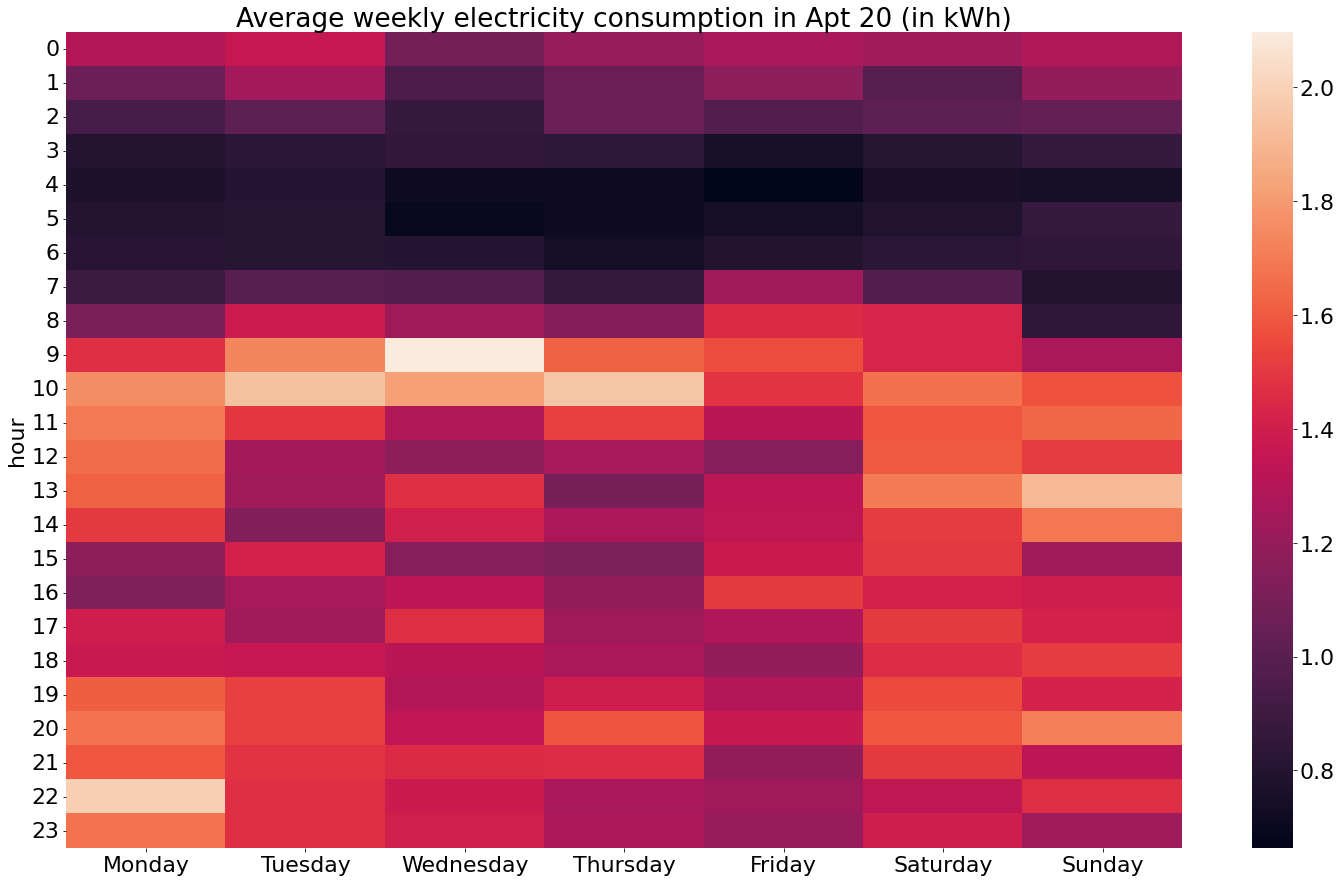

In [14]:
g=sns.heatmap(avg_pivot)
locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in Apt 20 (in kWh)")

# Single LSTM

In [73]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [74]:
def run_model(home: pd.Series, train_size=0.8, timesteps= 1, epochs=50, batch_size= 64, neurons=128):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    


    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #plot the predictions
    plt.plot(pred_test[f'true_{home.name}'])
    plt.plot(pred_test[f'simple_lstm_{home.name}'])
    plt.show()


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

In [ ]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    
    # pred_train ={}
    # pred_test = {}

    # rmse_train ={}
    # rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

In [75]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

## Hyperparameter Tuning

In [78]:
#install the package
import keras_tuner as kt
import keras.optimizers

In [79]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units',[24,64,128,256,512])))
  model.add(Dense(1, activation='relu'))
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3])), metrics=['mean_squared_error'])

  
  return model

In [80]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_mean_squared_error',
    max_trials=30)

In [85]:
timesteps=1

In [86]:
home = apts['apt_0']
# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [87]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 13 Complete [00h 00m 11s]
val_mean_squared_error: 0.0008049007155932486

Best val_mean_squared_error So Far: 0.0007712855003774166
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


In [95]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.001
Score: 0.0007712855003774166
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.001
Score: 0.0007757717976346612
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.0007857651798985898
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.0008049007155932486
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.1
Score: 0.0008378610946238041
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.1
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.1
Score: 0.012532583437860012


## Multivariate LSTM

In [96]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [97]:
values= apts.values
values = values.astype('float32')

In [98]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [104]:
apartments ={}


In [105]:
for i in reframed:
    for j in range(40,79):
        apartments[str(i)] = reframed.iloc[:, np.r_[0:39,j]]

# Federated Model

In [119]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [120]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [121]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds = scaler.inverse_transform(model.predict(X_test))
    loss = rmse(scaler.inverse_transform(Y_test), preds)
    print('comm_round: {} | loss_in_{}: {}'.format(comm_round,home,loss))
    return loss, preds

In [122]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test


In [123]:
comms_round = 10
    
#create optimizer
lr = 0.1 
loss='mean_squared_error'
metrics = ['mse', tf.keras.metrics.MeanAbsolutePercentageError()]
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [124]:
client_names = apts.columns

In [126]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(512, 1, 1) #Number of hidden units defined by hyperparameter tuning
        


In [127]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

In [129]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for house in apts:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(512)
        local_model.compile(loss=loss, 
                        optimizer=optimizer, #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test= prepare_task(apts[house])


        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(apts, house)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, house)


        pred_train[f"true_{house}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{house}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"simple_lstm_{house}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"simple_lstm_{house}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'single_{house}'] = rmse(pred_test[f'true_{house}'], pred_test[f'simple_lstm_{house}'])
        rmse_train[f'single_{house}'] = rmse(pred_train[f'true_{house}'], pred_train[f'simple_lstm_{house}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 | loss_in_apt_0: 0.8580651530654272
comm_round: 0 | loss_in_apt_1: 1.9711134370788763
comm_round: 0 | loss_in_apt_2: 2.18081307404297
comm_round: 0 | loss_in_apt_3: 1.814413175897367
comm_round: 0 | loss_in_apt_4: 1.9296573752149686
comm_round: 0 | loss_in_apt_5: 1.7033963698230616
comm_round: 0 | loss_in_apt_6: 2.1786167672384735
comm_round: 0 | loss_in_apt_7: 0.6586457887447703
comm_round: 0 | loss_in_apt_8: 1.6936011326167968
comm_round: 0 | loss_in_apt_9: 1.721556106938271
comm_round: 0 | loss_in_apt_10: 2.909585150433809
comm_round: 0 | loss_in_apt_11: 2.1984197464142112
comm_round: 0 | loss_in_apt_12: 0.7322507347254594
comm_round: 0 | loss_in_apt_13: 2.0432497869576105
comm_round: 0 | loss_in_apt_14: 0.39555743071794575
comm_round: 0 | loss_in_apt_15: 4.21110862889466
comm_round: 0 | loss_in_apt_16: 1.6793527745129764
comm_round: 0 | loss_in_apt_17: 1.454485926307782
comm_round: 0 | loss_in_apt_18: 1.9195559955211514
comm_round: 0 | loss_in_apt_19: 3.07733296140279

In [130]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results_apartments.csv")

In [131]:
# Results from 30.05: 10 comm rounds